## Imports

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np
import joblib
import math
import mlflow

## Getting the data

In [3]:
from influxdb import InfluxDBClient
import pandas as pd

client = InfluxDBClient(host = "influxus.itu.dk", port =8086, username = "lsda", password = "icanonlyread")
client.switch_database ("orkney")

def get_df(results):
    values = results.raw ["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame( values , columns = columns ) . set_index ("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime - index
    return df

# Get the last 90 days of power generation data
generation = client.query ("SELECT * FROM Generation where time > now()-90d") # Query written in InfluxQL

# Get the last 90 days of weather forecasts with the shortest lead time
wind = client.query("SELECT * FROM MetForecasts where time > now()-90d and time <= now() and Lead_hours = '1'") # Query written in InfluxQL

gen_df = get_df (generation)
wind_df = get_df (wind)

## Methods for custom transformations

In [4]:
# Convert direction for radian
def toRadian(x):
    match x:
        case 'E':
            return math.radians(0)
        case 'ENE':
            return math.radians(22.5)
        case 'NE':
            return math.radians(45)
        case 'NNE':
            return math.radians(67.5)
        case 'N':
            return math.radians(90)
        case 'NNW':
            return math.radians(112.5)
        case 'NW"':
            return math.radians(135)
        case 'WNW':
            return math.radians(157.5)
        case 'W':
            return math.radians(180)
        case 'WSW':
            return math.radians(202.5)
        case 'SW':
            return math.radians(225)
        case 'SSW':
            return math.radians(247.5)
        case 'S':
            return math.radians(270)
        case 'SSE':
            return math.radians(292.5)
        case 'SE':
            return math.radians(315)
        case 'ESE':
            return math.radians(337.5)

# Convert all directions in dataframe 'x' to radian
def dfToRadian(x):
    return x.applymap(toRadian)
    
# Perform linear interpolation on datafram 'x'
def linearInterpolation(x):
    return x.interpolate(method='linear')  

## Merge and split the dataset

In [5]:
plt.close("all")

# For aligning two dataframes on time
def mergeOnTime(df1, df2, delta):
    combined_df = pd.merge_asof(df1.iloc[:,2:], df2.iloc[:,[0,3]], on="time", tolerance=pd.Timedelta(delta))
    combined_df.set_index('time', inplace=True)
    return combined_df

combined_df = mergeOnTime(gen_df, wind_df, "3m")


def testSplit(df):
    X = df.drop("Total", axis = 1)
    y = df["Total"]
    tss = TimeSeriesSplit(n_splits = 3)
    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = testSplit(combined_df)

## Create pipelines

In [8]:
# Pipeline converting directions to radians, and performing linear interpolation to fill missing data
categorical_pipeline = Pipeline(steps=[
    ('one-hot', FunctionTransformer(dfToRadian)),
    ('interpolate', FunctionTransformer(linearInterpolation))
])

# Perform independent transformations on columns "Direction" and "Speed"
column_processor = ColumnTransformer(transformers=[
    ('categorical', categorical_pipeline, ["Direction"]),
    ('interpolate', FunctionTransformer(linearInterpolation), ["Speed"])
])
 
# Impute the final missing values and scale
full_processor = Pipeline(steps=[
    ('fill', column_processor),
    ('impute', SimpleImputer(strategy='most_frequent')),
    ("scale", MinMaxScaler())
])

In [35]:
import os
#os.environ["AWS_ACCESS_KEY_ID"] = "minio"
#os.environ["AWS_SECRET_ACCESS_KEY"] = "minio123"
#os.environ["MLFLOW_S3_ENDPOINT_URL"] = f"http://minio-server:9000"
mlflow.set_tracking_uri('http://training.itu.dk:5000/')
experiment = mlflow.set_experiment("magnj - tracking")

## Test different regression models

In [34]:
import mlflow.sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from urllib.parse import urlparse

# Simular pipeline, but transforming PolynomialFeatures 
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

degree = 4
with mlflow.start_run():

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    linReg = LinearRegression()

    polynominal_pipeline = Pipeline(steps=[
        ("preprocessor", full_processor),
        ('polynominal', poly),
        ('model', linReg)
    ])

    # Parameters poly:'degree': 4, 'include_bias': False, 'interaction_only': False, 'order': 'C' 
    # Parameters linReg:'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False

    # Estimate error for polynominal pipeline
    poly_pipeline_model = polynominal_pipeline.fit(X_train, y_train)
    poly_preds = poly_pipeline_model.predict(X_test)
    (rmse, mae, r2) = eval_metrics(y_test, poly_preds)
    
    print("Polynominal linear regression with degree: " + str(degree))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    
    mlflow.log_param("degree", 4)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    
    """
    if tracking_url_type_store != "file":
        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(poly_pipeline_model, "model", registered_model_name="Linear_poly_regression")
    else:
        mlflow.sklearn.log_model(poly_pipeline_model, "model")

    #print("Polynominal pipeline: " + str(mean_absolute_error(y_test, poly_preds)) + "\n")
    """

Polynominal linear regression with degree: 4
  RMSE: 4.0398683640699184
  MAE: 3.155971196826982
  R2: 0.7598943461154408


## Compare old and new model

In [34]:
# Load and predict from old model
old_model = joblib.load("Best_model.joblib")
old_preds = old_model.predict(X_test)
print("Mean absolute error from old model: " + str(mean_absolute_error(y_test, old_preds)) + "\n")

# Load and predict from new model
new_model = polynominal_pipeline.fit(X_train, y_train)
new_preds = new_model.predict(X_test)
print("Mean absolute error from new model: " + str(mean_absolute_error(y_test, new_preds)) + "\n")

Mean absolute error from old model: 5.1771608740898625

Mean absolute error from new model: 4.887145792628357



['New_best_model.joblib']

## Do forecasting with the best one

<AxesSubplot: xlabel='time'>

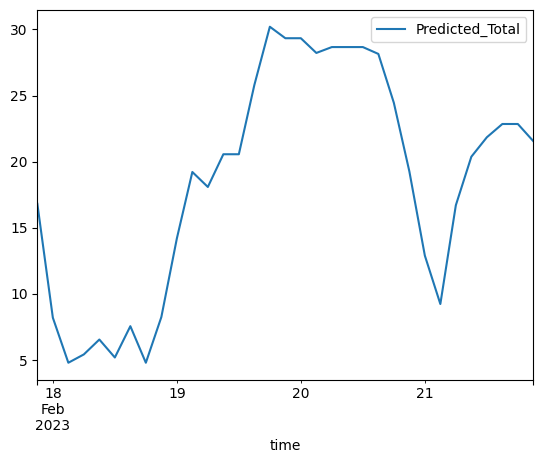

In [40]:
# Get all future forecasts regardless of lead time
forecasts = client.query(
    "SELECT * FROM MetForecasts where time > now()"
) # Query written in InfluxQL
for_df = get_df(forecasts)

# Limit to only the newest source time
newest_source_time = for_df["Source_time"].max()
newest_forecasts = for_df.loc[for_df["Source_time"] == newest_source_time].copy()

# Preprocess the forecasts and do predicitons in one fell swoop using your best pipeline
best_model = joblib.load("New_best_model.joblib")
for_values = best_model.predict(newest_forecasts)



newest_forecasts["Predicted_Total"] = for_values
newest_forecasts.plot(y=["Predicted_Total"])